# Random Forest Demo

This is a really simple example of how random forests can improve a decision tree's ability to generalise.

To make it easy to understand I've written this without using any Python 3rd party libraries except for Numpy.
So you need to:

* install Python 3
* install Jupyter Notebook
* install Numpy
* download the Boston Housing Dataset from https://archive.ics.uci.edu/ml/datasets/Housing and put it in a subfolder called data.

I've used a very simple decision tree algorithm that just bisects the dataset repeatedly on the median of each attribute. This is concise and easy to understand.

Then I have made 100 decision trees by taking random subsets of training instances and only allowing the trees to see random subsets of the attributes.

At the end you can see that a random forest of 100 trees each trained on 10-20% of data and attributes outperforms a single decision tree trained on the whole dataset, when they're evaluated on a held-out test dataset.

In [1]:
import os, re
import numpy as np
%matplotlib inline
import math
import matplotlib.pyplot as plt
import random

# Load columns

In [2]:
cols = []
inattrs = False
with open("data/housing.names.txt") as f:
    for l in f:
        if "Missing Attribute Values" in l:
            inattrs = False
        if inattrs:
            c = re.sub("\s+\d+\.\s+|\n", "", l)
            c = re.sub("\s+.+", "", c)
            if len(c) > 0:
                cols.append(c)
        if "Attribute Information" in l:
            inattrs = True
print (cols)

['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']


# Load data

10% of the training data is split off as test data

In [3]:
data = []
test_data = []
with open("data/housing.data.txt") as f:
    for l in f:
        cells = re.split("\s+", re.sub("^\s+|\s+$", "", l))
        datum = [float(c) for c in cells]
        if random.random() < 0.1:
            test_data.append(datum)
        else:
            data.append(datum)

Here's a preview of the first house in the dataset:

In [4]:
for idx, c in enumerate(cols):
    print (c, "=", data[0][idx])

CRIM = 0.00632
ZN = 18.0
INDUS = 2.31
CHAS = 0.0
NOX = 0.538
RM = 6.575
AGE = 65.2
DIS = 4.09
RAD = 1.0
TAX = 296.0
PTRATIO = 15.3
B = 396.9
LSTAT = 4.98
MEDV = 24.0


Plot of MEDV vs CRIM

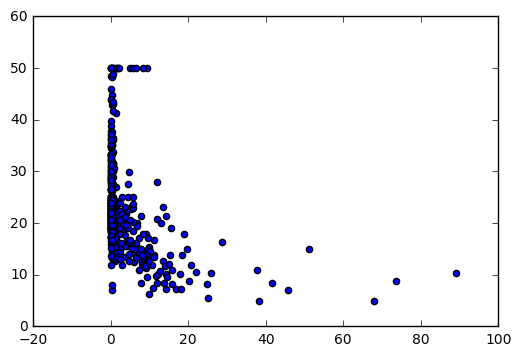

In [5]:
plt.scatter([r[0] for r in data], [r[-1] for r in data])
plt.show()

Plot of MEDV as a function of LSTAT

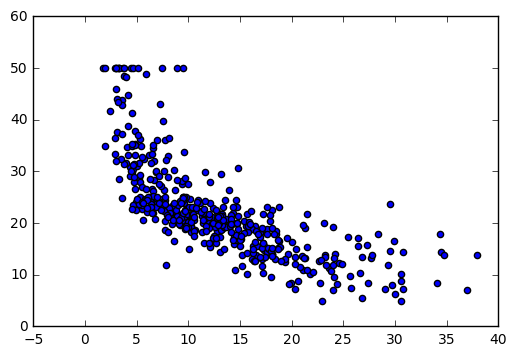

In [6]:
plt.scatter([r[-2] for r in data], [r[-1] for r in data])
plt.show()

# Make a decision tree

Here I'm using a very quick and dirty algorithm:

* recursively iterate over the data
* at each stage identify the attribute which provides the biggest split in the output class if you split the data at the median of the attribute's values.
* if there's only 1 item in the data you're looking at, return a leaf node

In [7]:
def build_tree(tmp_data, depth = 0, cols_to_exclude = []):
    if len(tmp_data) < 2:
        pred = tmp_data[0][len(cols) - 1]
        return (pred, cols[-1] + " = " + str(pred))
    all_mean_diffs = []
    for c in range(len(cols) - 1):
        if c in cols_to_exclude:
            continue
        values = [d[c] for d in tmp_data]
        median = np.median(values)
        subsetwise_classification_means = []
        got_nan = False
        for subset_id in (-1, 1):
            if subset_id == -1:
                subset_classifications = [d[len(cols) - 1] for d in tmp_data if d[c] < median]
            else:
                subset_classifications = [d[len(cols) - 1] for d in tmp_data if d[c] >= median]
            subset_mean = np.mean(subset_classifications)
            if math.isnan(subset_mean):
                got_nan = True
            subsetwise_classification_means.append(subset_mean)
        if not got_nan:
            #print (subsetwise_classification_means)
            diff = subsetwise_classification_means[0] - subsetwise_classification_means[1]
            all_mean_diffs.append({"col":c,"diff":diff,"means":subsetwise_classification_means,"median":median})
    cols_sorted_by_separation_potential = sorted(all_mean_diffs, key=lambda f:(-np.abs(f['diff'])))
    best_separation_rule = cols_sorted_by_separation_potential[0]
    operator = "<"
    best_col_index = best_separation_rule["col"]
    median = best_separation_rule["median"]
    rule_string = cols[best_col_index] + " " + operator + " " + str(median)
    rule = (best_col_index, operator, median, rule_string)
    subset_1 = [d for d in tmp_data if d[best_col_index]  < median]
    subset_2 = [d for d in tmp_data if d[best_col_index]  >= median]
    b1 = build_tree(subset_1, depth+1)
    b2 = build_tree(subset_2, depth+1)
    tree = (rule, b1, b2)
    return tree


In [8]:
tree = build_tree(data)

/Users/thomaswood/anaconda/envs/py35/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/thomaswood/anaconda/envs/py35/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [9]:
def display_tree(tree, depth = 0):
    if len(tree) > 2:
        tree_as_string = tree[0][-1]
    else:
        tree_as_string = tree[1]
    print ((" " * depth), tree_as_string)
    if len(tree) > 2:
        for t in [tree[1], tree[2]]:
            display_tree(t, depth + 1)

In [10]:
display_tree(tree)

 LSTAT < 11.45
  RM < 6.527
   RM < 6.1745
    CRIM < 0.09164
     PTRATIO < 18.6
      INDUS < 3.845
       RAD < 4.0
        CRIM < 0.03548
         MEDV = 24.1
         CRIM < 0.041835
          MEDV = 20.9
          MEDV = 21.9
        INDUS < 3.24
         MEDV = 18.6
         B < 382.44
          MEDV = 19.8
          CRIM < 0.05498
           MEDV = 19.4
           MEDV = 19.3
       LSTAT < 9.43
        INDUS < 5.64
         MEDV = 22.2
         CRIM < 0.06623
          MEDV = 23.4
          MEDV = 23.9
        INDUS < 4.845
         CRIM < 0.077345
          MEDV = 23.2
          MEDV = 22.6
         CRIM < 0.06268
          MEDV = 20.5
          MEDV = 21.7
      AGE < 46.05
       INDUS < 5.19
        MEDV = 18.2
        RAD < 5.0
         MEDV = 22.0
         RM < 6.037
          CRIM < 0.067555
           MEDV = 19.0
           MEDV = 21.0
          RM < 6.059
           MEDV = 21.1
           CRIM < 0.060065
            MEDV = 20.6
            MEDV = 20.8
       RAD < 4.0

In [11]:
def classify(tree, instance):
    if len(tree) > 2:
        col, sign, value, desc = tree[0]
        if instance[col] < value:
            return classify(tree[1], instance)
        else:
            return classify(tree[2], instance)
        return None
    else:
        return tree[0]

Try predicting the value of the first house in the dataset.

In [12]:
print (data[0])

[0.00632, 18.0, 2.31, 0.0, 0.538, 6.575, 65.2, 4.09, 1.0, 296.0, 15.3, 396.9, 4.98, 24.0]


In [13]:
print (classify(tree, data[0]))

24.0


The value comes out at 24, exactly the correct value! This is because the decision tree is overly complex and tailored to the exact values present in the dataset.

Now we try predicting all the values from the training dataset:

correlation
 [[ 1.  1.]
 [ 1.  1.]]


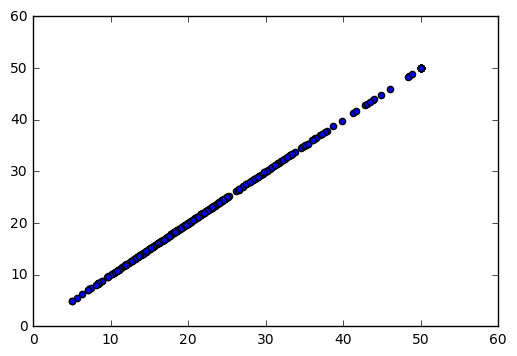

In [14]:
ground_truth = [d[-1] for d in data]
pred = [classify(tree, d) for d in data]
print ('correlation\n', np.corrcoef(ground_truth, pred))
plt.scatter(ground_truth, pred)
plt.show()

You can see the decision tree is working because it's perfectly predicted *every* instance in the training data.

Of course this is silly - it's completely overfit the training data and memorised the attributes of every instance.

A model like this is not completely useless but it will not generalise well. We can prove this by trying it on the test data.

# Now try the model on the test data

correlation
 [[ 1.         0.6992103]
 [ 0.6992103  1.       ]]


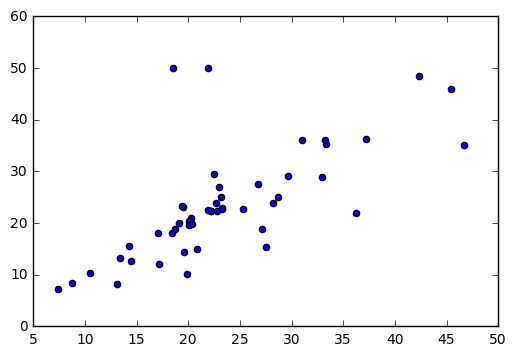

In [15]:
ground_truth = [d[-1] for d in test_data]
pred = [classify(tree, d) for d in test_data]
print ('correlation\n', np.corrcoef(ground_truth, pred))
plt.scatter(ground_truth, pred)
plt.show()

You can see there's a correlation but it's not perfect

# Now try with random forest

In [16]:
forest = []
num_trees_in_forest = 1000
for i in range(num_trees_in_forest):
    tmpdata = [d for d in data if random.random() < 0.2]
    tmp_cols_to_exclude = []
    for x in range(len(cols)):
        tmp_cols_to_exclude.append(x)
    random.shuffle(tmp_cols_to_exclude)
    tmp_cols_to_exclude = tmp_cols_to_exclude[:2]
    tree = build_tree(tmpdata, cols_to_exclude = tmp_cols_to_exclude)
    forest.append(tree)

/Users/thomaswood/anaconda/envs/py35/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/thomaswood/anaconda/envs/py35/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [17]:
def forest_classify(forest, instance):
    results = []
    for tree in forest:
        result = classify(tree, instance)
        results.append(result)
    return np.average(results)

In [18]:
forest_classify(forest, data[0])

26.637199999999996

In [19]:
forest_classify(forest, data[1])

22.771000000000001

correlation
 [[ 1.          0.95142868]
 [ 0.95142868  1.        ]]


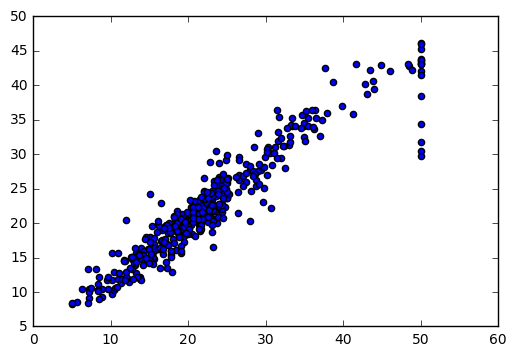

In [20]:
ground_truth = [d[-1] for d in data]
pred = [forest_classify(forest, d) for d in data]
print ('correlation\n', np.corrcoef(ground_truth, pred))
plt.scatter(ground_truth, pred)
plt.show()

Now test the random forest on the test data.

correlation
 [[ 1.          0.84978585]
 [ 0.84978585  1.        ]]


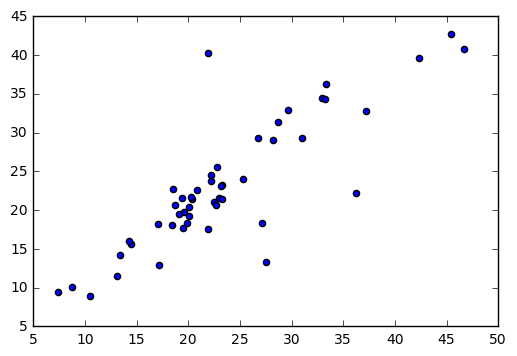

In [21]:
ground_truth = [d[-1] for d in test_data]
pred = [forest_classify(forest, d) for d in test_data]
print ('correlation\n', np.corrcoef(ground_truth, pred))
plt.scatter(ground_truth, pred)
plt.show()

You can see that the random forest has performed better than the single decision tree on unseen data, even though the single tree performed perfectly on the test data!